In [2]:
import pandas as pd
import numpy as np
import catboost
import torch
from torch import nn
from torch.utils.data import DataLoader

C:\Users\croxw\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [52]:
!python -V

Python 3.11.5


In [3]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import tqdm
import random

In [4]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [5]:
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [5]:
def show_event_close_range(df, event, n=3):
    indexes = []
    new_index = df.loc[df['event_type']==event].index
    for ind in new_index:
        for i in range(-n, n+1):
            if ind + i > 0:
                indexes.append(ind+i)
    return df.loc[df.index.isin(indexes)]

def adapt_dataset(df, n):
    cols = df.columns
    new_df = pd.DataFrame(columns=cols)
    adg = pd.unique(df.adgroup_id)
    for ad in tqdm.tqdm(adg):
        temp_df = df.loc[df.adgroup_id == ad]
        if len(temp_df) < n:
            new_df = pd.concat([new_df, temp_df])
            size = n - len(temp_df)
            add_df = pd.DataFrame(columns=cols, data=[ ['9999-12-31',ad,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,'END']]* size )
            add_df['rn'] = list(range(n-size, n))
            new_df = pd.concat([new_df, add_df])
        else:
            new_df = pd.concat([new_df, temp_df.reset_index(drop=True)[:n] ])
    return new_df

In [102]:
dm = df.groupby(by=['adgroup_id', 'date']).agg({'event_type': 'count'}).reset_index()
dm.loc[dm.event_type > 1]

,adgroup_id,date,event_type
9,25358,2024-01-05,2
12,25358,2024-01-08,3
61,25358,2024-02-27,2
68,25358,2024-03-06,2
86,25358,2024-03-25,2
...,...,...,...
66431,131703,2024-12-01,3
66435,131704,2024-12-01,4
66449,131707,2024-12-01,3
66577,131901,2024-12-01,3


In [49]:
df = pd.read_csv('dataset_classes.csv')
df = df.loc[df.event_type != 'CREATE_CAMPAIGN_CRITERION_AD_SCHEDULE'].reset_index(drop=True)

In [114]:
dadg = df[['date', 'adgroup_id']].drop_duplicates().reset_index(drop=True)

In [126]:
df = df.sort_values(by=['adgroup_id', 'date', 'rn', 'prior'])
new_df = pd.DataFrame(columns=df.columns)
dadg = df[['date', 'adgroup_id']].drop_duplicates().reset_index(drop=True)
for date, adg in tqdm.tqdm(zip(dadg['date'], dadg['adgroup_id'])):
    new_df = pd.concat([new_df, df.loc[(df.adgroup_id == adg) & (df.date == date)].reset_index(drop=True)[:1]])
print(len(new_df))

0it [00:00, ?it/s]C:\Users\croxw\AppData\Local\Temp\ipykernel_19072\283770664.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, df.loc[(df.adgroup_id == adg) & (df.date == date)].reset_index(drop=True)[:1]])
66858it [04:12, 264.61it/s]

66858


In [130]:
new_df = new_df.reset_index(drop=True)

In [156]:
max_conv = [1] * 66858
for index, row in tqdm.tqdm(new_df[['adgroup_id', 'new_value']].iterrows()):
    if row['new_value'] == 'TARGET_CPA':
        adg = row['adgroup_id']
        ind = index
        if len(new_df.loc[(new_df.new_value == 'MAXIMIZE_CONVERSIONS') & (new_df.index > ind) & (new_df.adgroup_id == adg)]) > 0:
            max_ind = min(max(new_df.loc[new_df.adgroup_id==adg].index), min(new_df.loc[(new_df.new_value == 'MAXIMIZE_CONVERSIONS') & (new_df.index > ind) & (new_df.adgroup_id == adg)].index))
        else:
            max_ind = max(new_df.loc[new_df.adgroup_id==adg].index)
        for i in range(ind, max_ind):
            max_conv[i] = 0
new_df['is_max_conversion'] = max_conv

66858it [00:14, 4623.89it/s]


In [157]:
new_df

,date,adgroup_id,rn,impressions,bought,cost,sold,earned,cpa,rpc,...,max_cpc,campaign_budget_amount,change_date_time,event_type,old_value,new_value,prior,change_rate,cat,is_max_conversion
0,2023-12-27,25358,1,914,49,3.0900,1,0.0764,0.063061,13.0890,...,0.01,3.0,NaN,NO_CHANGE,NaN,NaN,2,NaN,NaN,1
1,2023-12-28,25358,2,404,24,0.7100,3,1.5408,0.029583,1.9470,...,0.01,3.0,2023-12-29 13:14:09,UPDATE_CAMPAIGN_BUDGET_AMOUNT,3,11,2,3.666667,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,1
2,2023-12-29,25358,3,4157,308,10.8400,59,22.0487,0.035195,2.6759,...,0.01,11.0,NaN,UPDATE_CAMPAIGN_BUDGET_AMOUNT,3.0000,11.0000,2,3.666667,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,1
3,2023-12-30,25358,4,3950,338,10.7500,59,15.3252,0.031805,3.8499,...,0.01,11.0,NaN,NO_CHANGE,NaN,NaN,2,NaN,NaN,1
4,2023-12-31,25358,5,3865,255,11.1800,50,8.1239,0.043843,6.1547,...,0.01,11.0,NaN,NO_CHANGE,NaN,NaN,2,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66853,2024-12-03,132950,1,92,7,1.0918,0,0.0000,0.155971,NaN,...,0.00,1.0,NaN,NO_CHANGE,NaN,NaN,2,NaN,NaN,1
66854,2024-12-03,132951,1,151,8,1.1753,0,0.0000,0.146913,NaN,...,0.00,1.0,NaN,NO_CHANGE,NaN,NaN,2,NaN,NaN,1
66855,2024-12-03,132952,1,199,8,1.2000,0,0.0000,0.150000,NaN,...,0.00,1.0,NaN,NO_CHANGE,NaN,NaN,2,NaN,NaN,1
66856,2024-12-03,132953,1,65,6,1.2546,0,0.0000,0.209100,NaN,...,0.00,1.0,NaN,NO_CHANGE,NaN,NaN,2,NaN,NaN,1


In [161]:
new_df.loc[new_df.new_value == 'TARGET_CPA', 'cat'] = 'STRATEGY_CPA'
new_df.loc[new_df.new_value == 'MAXIMIZE_CONVERSIONS', 'cat'] = 'STRATEGY_CONVERSION'

In [166]:
new_df.event_type.value_counts()

event_type
NO_CHANGE                        30947
UPDATE_CAMPAIGN_BUDGET_AMOUNT    23495
UPDATE_CAMPAIGN                   7976
UPDATE_AD_GROUP_TARGET_CPA        4331
UPDATE_AD_GROUP_STATUS             109
Name: count, dtype: int64

In [167]:
new_df.loc[(new_df.event_type == 'UPDATE_CAMPAIGN')]

,date,adgroup_id,rn,impressions,bought,cost,sold,earned,cpa,rpc,...,max_cpc,campaign_budget_amount,change_date_time,event_type,old_value,new_value,prior,change_rate,cat,is_max_conversion
12,2024-01-08,25358,13,12561,591,35.12,162,37.0610,0.059425,4.3712,...,0.01,42.0,2024-01-09 09:16:16,UPDATE_CAMPAIGN,MAXIMIZE_CONVERSIONS,TARGET_CPA,1,NaN,STRATEGY_CPA,0
257,2024-01-10,26848,1,601,23,1.14,4,1.7751,0.049565,2.2534,...,0.01,3.0,2024-01-11 09:35:17,UPDATE_CAMPAIGN,MAXIMIZE_CONVERSIONS,TARGET_CPA,1,NaN,STRATEGY_CPA,0
584,2024-01-23,26855,14,63096,2398,113.28,627,417.9334,0.047239,1.5002,...,0.01,141.0,2024-01-24 19:24:07,UPDATE_CAMPAIGN,MAXIMIZE_CONVERSIONS,TARGET_CPA,1,NaN,STRATEGY_CPA,0
694,2024-05-19,26855,125,1322,52,3.66,43,1.9790,0.070385,21.7281,...,0.01,31.0,2024-05-20 11:22:44,UPDATE_CAMPAIGN,ENABLED,PAUSED,1,NaN,NaN,0
703,2024-01-17,35830,6,6883,249,12.32,37,17.5597,0.049478,2.1071,...,0.01,15.0,2024-01-18 09:56:31,UPDATE_CAMPAIGN,MAXIMIZE_CONVERSIONS,TARGET_CPA,1,NaN,STRATEGY_CPA,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66440,2024-12-01,131705,3,323,18,0.99,1,0.0191,0.055000,52.3560,...,0.01,1.0,2024-12-02 11:43:25,UPDATE_CAMPAIGN,ENABLED,PAUSED,1,NaN,NaN,1
66449,2024-12-01,131707,3,181,18,1.05,4,0.7816,0.058333,5.1177,...,0.01,1.0,2024-12-02 12:15:19,UPDATE_CAMPAIGN,MAXIMIZE_CONVERSIONS,TARGET_CPA,1,NaN,STRATEGY_CPA,0
66453,2024-12-01,131708,3,349,15,0.89,1,0.0575,0.059333,17.3913,...,0.01,1.0,2024-12-02 12:18:13,UPDATE_CAMPAIGN,ENABLED,PAUSED,1,NaN,NaN,1
66577,2024-12-01,131901,3,57,9,1.01,2,0.3515,0.112222,5.6899,...,0.01,1.0,2024-12-02 10:39:26,UPDATE_CAMPAIGN,MAXIMIZE_CONVERSIONS,TARGET_CPA,1,NaN,STRATEGY_CPA,0


In [171]:
indxs = new_df.loc[(new_df.event_type == 'UPDATE_CAMPAIGN') & (new_df.new_value.isin(['PAUSED', 'ENABLED']))].index
new_df = new_df.loc[~new_df.index.isin(indxs)].reset_index(drop=True)
len(new_df)

61642

#df = pd.read_csv('dataset.csv')
df = pd.read_csv('dataset_less_classes.csv')

np.quantile(df.groupby('adgroup_id').count()['rn'], 0.99)

In [172]:
df = new_df

In [173]:
df["event_lagged"] = df.event_type.shift(1)
df['target'] = df['cat'].combine_first(df['event_type'])

In [29]:
ndf = df.loc[~( ((df.event_type == 'CREATE_AD_GROUP') | (df.event_type == 'CREATE_CAMPAIGN_CRITERION_AD_SCHEDULE') | (df.event_type == 'UPDATE_AD_GROUP_STATUS')) | ((df.event_type == 'UPDATE_AD_GROUP_STATUS') & (df.event_lagged == 'CREATE_AD_GROUP')) | (df.event_type == 'CREATE_AD_GROUP') )][['adgroup_id', 'date', 'impressions', 'bought', 'cost', 'sold', 'earned', 'profit', 'max_cpa', 'max_cpc', 'campaign_budget_amount', 'rn', 'is_max_conversion', 'target']].drop_duplicates().reset_index(drop=True)#, 'old_value', 'new_value']]
ndf = ndf.loc[ndf.target!='UPDATE_CAMPAIGN_BUDGET_AMOUNT'].reset_index(drop=True)
#ndf = ndf.dropna()

NameError: name 'df' is not defined

In [53]:
ndf

,adgroup_id,date,impressions,bought,cost,sold,earned,profit,max_cpa,max_cpc,...,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,cpa_flag,impr_flag,cost_rate_lag,cost_rate_dynamic,is_first_days,predicted,y_true
0,25358,2023-12-28,404,24,0.7100,3,1.5408,0.8308,5.0,0.01,...,0,0,0,0,0,1.030000,0.793333,0,NO_CHANGE,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
1,25358,2023-12-29,4157,308,10.8400,59,22.0487,11.2087,5.0,0.01,...,0,0,1,0,0,0.236667,-0.748788,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
2,25358,2023-12-30,3950,338,10.7500,59,15.3252,4.5752,5.0,0.01,...,0,0,1,0,0,0.985455,0.008182,0,NO_CHANGE,NO_CHANGE
3,25358,2023-12-31,3865,255,11.1800,50,8.1239,-3.0561,5.0,0.01,...,0,0,0,0,0,0.977273,-0.039091,0,STRATEGY_CPA,NO_CHANGE
4,25358,2024-01-01,3522,256,9.0900,55,15.0385,5.9485,5.0,0.01,...,0,0,0,0,1,1.016364,0.190000,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,NO_CHANGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42606,131904,2024-12-03,6,1,0.1232,1,0.0309,-0.0923,0.0,0.00,...,0,0,1,0,0,1.155000,1.093400,0,NO_CHANGE,NO_CHANGE
42607,131905,2024-11-30,100,10,0.9000,2,0.1555,-0.7445,5.0,0.01,...,0,0,0,0,0,1.100000,0.200000,0,NO_CHANGE,NO_CHANGE
42608,131905,2024-12-01,156,13,0.9200,2,0.9055,-0.0145,5.0,0.01,...,0,0,0,0,0,0.900000,-0.020000,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
42609,131905,2024-12-02,302,27,2.1600,2,0.2163,-1.9437,5.0,0.01,...,0,0,1,0,0,0.920000,-0.160000,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP


In [178]:
ndf['cum_profit'] = ndf.groupby('adgroup_id')['profit'].cumsum()

In [179]:
ndf['cost_rate'] = ndf['cost'] / ndf['campaign_budget_amount']

In [180]:
shifted = ndf.groupby("adgroup_id")['profit'].shift(1)
shifted_impr = ndf.groupby("adgroup_id")['impressions'].shift(1)
shifted_tgt= ndf.groupby("adgroup_id")['target'].shift(1)
shifted_cpa = ndf.groupby("adgroup_id")['max_cpa'].shift(1)
shifted_budget= ndf.groupby("adgroup_id")['campaign_budget_amount'].shift(1)
#ndf['impr'] = np.log(ndf['impressions'])
ndf['profit_lag'] = shifted
ndf['impressions_lag'] = shifted_impr
ndf['tgt_lag'] = shifted_tgt
ndf['profit_dif'] = (ndf['profit'] - ndf['profit_lag']) / (ndf['cum_profit'])
ndf['profit_rate'] = ndf['profit'] / ndf['cum_profit']
ndf['impr_dynamic'] = (ndf['impressions'] - ndf['impressions_lag']) / 1e3
ndf['profit_dif'] = ndf['profit_dif'].fillna(0.15)
ndf['impr_dynamic'] = ndf['impr_dynamic'].fillna(0.01)
ndf['profit_cond'] = ndf['profit'].apply(lambda x: 1 if x > 15 else 0)

ndf = pd.get_dummies(ndf, columns=['tgt_lag'], dtype=int)

def mark_cpa(a,b,c):
    return 1 if a<0 and b>0 and c>5 else 0
def mark_impr(a,b,c):
    return 1 if a<10000 and b>5 and c>5 else 0

ndf['cpa_flag'] = ndf.apply(lambda x: mark_cpa(x['profit_dif'], x['impr_dynamic'], x['rn']), axis=1)
ndf['impr_flag'] = ndf.apply(lambda x: mark_impr(x['impressions'], x['profit'], x['rn']), axis=1)

C:\Users\croxw\AppData\Local\Temp\ipykernel_19072\2333258178.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ndf['impr_dynamic'] = ndf['impr_dynamic'].fillna(0.01)


In [181]:
shifted_costrate = ndf.groupby("adgroup_id")['cost_rate'].shift(1)
ndf['cost_rate_lag'] = shifted_costrate
ndf['cost_rate_dynamic'] = ndf['cost_rate_lag'] - ndf['cost_rate']
ndf['cost_rate_dynamic'] = ndf['cost_rate_dynamic'].fillna(0.15)

In [182]:
ind = ndf.loc[ndf.rn.isin([1,2,3])].index
ndf['is_first_days'] = 0
ndf.loc[ndf.index.isin(ind)]['is_first_days'] = 1

C:\Users\croxw\AppData\Local\Temp\ipykernel_19072\1046676016.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf.loc[ndf.index.isin(ind)]['is_first_days'] = 1


In [183]:
lst = []
dct = dict(ndf['adgroup_id'].value_counts())
for adg in dct:
    if dct[adg]==64:
        lst.append(adg)
tdf = ndf.loc[ndf['adgroup_id'].isin(lst)].reset_index(drop=True)

In [184]:
ndf = ndf.dropna().reset_index(drop=True)

In [185]:
ndf

,adgroup_id,date,impressions,bought,cost,sold,earned,profit,max_cpa,max_cpc,...,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_UP,tgt_lag_UPDATE_CAMPAIGN,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,cpa_flag,impr_flag,cost_rate_lag,cost_rate_dynamic,is_first_days
0,25358,2023-12-28,404,24,0.7100,3,1.5408,0.8308,5.0,0.01,...,0,0,0,0,0,0,0,1.030000,0.793333,0
1,25358,2023-12-29,4157,308,10.8400,59,22.0487,11.2087,5.0,0.01,...,0,0,0,0,1,0,0,0.236667,-0.748788,0
2,25358,2023-12-30,3950,338,10.7500,59,15.3252,4.5752,5.0,0.01,...,0,0,0,0,1,0,0,0.985455,0.008182,0
3,25358,2023-12-31,3865,255,11.1800,50,8.1239,-3.0561,5.0,0.01,...,0,0,0,0,0,0,0,0.977273,-0.039091,0
4,25358,2024-01-01,3522,256,9.0900,55,15.0385,5.9485,5.0,0.01,...,0,0,0,0,0,0,1,1.016364,0.190000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51275,132298,2024-12-03,14,0,0.0000,0,0.0000,0.0000,0.0,0.00,...,0,0,0,0,0,0,0,1.060000,1.060000,0
51276,132299,2024-12-03,18,2,0.1553,1,0.0186,-0.1367,0.0,0.00,...,0,0,0,0,0,0,0,1.030000,0.978233,0
51277,132300,2024-12-03,98,9,0.9194,1,0.4037,-0.5157,0.0,0.00,...,0,0,0,0,0,0,0,1.080000,0.773533,0
51278,132301,2024-12-03,163,10,0.9003,1,0.0252,-0.8751,0.0,0.00,...,0,0,0,0,0,0,0,1.230000,0.929900,0


In [186]:
ndf.columns

Index(['adgroup_id', 'date', 'impressions', 'bought', 'cost', 'sold', 'earned',
       'profit', 'max_cpa', 'max_cpc', 'campaign_budget_amount', 'rn',
       'is_max_conversion', 'target', 'cum_profit', 'cost_rate', 'profit_lag',
       'impressions_lag', 'profit_dif', 'profit_rate', 'impr_dynamic',
       'profit_cond', 'tgt_lag_NO_CHANGE', 'tgt_lag_STRATEGY_CONVERSION',
       'tgt_lag_STRATEGY_CPA', 'tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_DOWN',
       'tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_UP', 'tgt_lag_UPDATE_CAMPAIGN',
       'tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT',
       'tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN',
       'tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP', 'cpa_flag', 'impr_flag',
       'cost_rate_lag', 'cost_rate_dynamic', 'is_first_days'],
      dtype='object')

In [6]:
features = ['impressions', 'impr_dynamic', 'cpa_flag', 'impr_flag', 'bought', 'cost', 'sold', 
            'earned', 'profit', 'profit_cond', 'cost_rate', 'cost_rate_dynamic', 'profit_dif', 'profit_rate', 
            'cum_profit', 'max_cpa', 'max_cpc', 'rn', 'is_first_days', 'campaign_budget_amount', 'is_max_conversion',
       'tgt_lag_NO_CHANGE', 
       'tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_DOWN',
       'tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_UP',
       'tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN',
       'tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP', 'target']

In [787]:
show_event_close_range(ndf, 'UPDATE_AD_GROUP_TARGET_CPA_DOWN', n=4).head(50)[features + ['pred_label']]

,impressions,impr_dynamic,bought,cost,sold,earned,profit,profit_cond,cost_rate,cost_rate_dynamic,profit_dif,profit_rate,cum_profit,max_cpa,max_cpc,rn,is_first_days,campaign_budget_amount,target,pred_label
7,4397,1.473,253,10.40,79,22.4918,12.0918,0,0.945455,-0.042727,-0.254851,0.181067,66.7807,5.00,0.01,9,0,11.0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
8,5094,0.697,279,11.37,66,32.4455,21.0755,1,0.541429,0.404026,0.102255,0.239886,87.8562,5.00,0.01,10,0,21.0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
9,11663,6.569,583,32.58,157,60.1598,27.5798,1,0.775714,-0.234286,0.056346,0.238919,115.4360,5.00,0.01,11,0,42.0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
10,10469,-1.194,556,41.19,172,53.6037,12.4137,0,0.980714,-0.205000,-0.118624,0.097096,127.8497,5.00,0.01,12,0,42.0,NO_CHANGE,NO_CHANGE
11,12561,2.092,591,35.12,162,37.0610,1.9410,0,0.836190,0.144524,-0.080689,0.014955,129.7907,5.00,0.01,13,0,42.0,UPDATE_AD_GROUP_TARGET_CPA_DOWN,NO_CHANGE
12,10716,-1.845,466,17.90,106,38.2615,20.3615,1,0.426190,0.410000,0.122679,0.135606,150.1522,0.25,0.01,14,0,42.0,NO_CHANGE,NO_CHANGE
13,5445,-5.271,284,11.09,72,27.5929,16.5029,1,0.264048,0.162143,-0.023153,0.099024,166.6551,0.25,0.01,15,0,42.0,UPDATE_AD_GROUP_TARGET_CPA_UP,NO_CHANGE
14,17798,12.353,776,33.73,158,50.6601,16.9301,1,0.803095,-0.539048,0.002327,0.092219,183.5852,0.29,0.01,17,0,42.0,NO_CHANGE,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
15,12786,-5.012,545,34.51,121,41.9833,7.4733,0,0.821667,-0.018571,-0.049497,0.039115,191.0585,0.29,0.01,18,0,42.0,NO_CHANGE,NO_CHANGE
16,17631,4.845,694,27.26,111,33.3441,6.0841,0,0.649048,0.172619,-0.007047,0.030861,197.1426,0.29,0.01,19,0,42.0,NO_CHANGE,NO_CHANGE


In [752]:
val = 15

print(len(ndf.loc[(ndf.target=='UPDATE_AD_GROUP_TARGET_CPA_UP') & (ndf.profit > val)]))
print(len(ndf.loc[(ndf.target=='UPDATE_AD_GROUP_TARGET_CPA_UP') & (ndf.profit < val)]))
print(len(ndf.loc[(ndf.target=='UPDATE_AD_GROUP_TARGET_CPA_DOWN') & (ndf.profit > val)]))
print(len(ndf.loc[(ndf.target=='UPDATE_AD_GROUP_TARGET_CPA_DOWN') & (ndf.profit < val)]))

306
2068
232
3537


(array([2.000e+00, 4.000e+00, 6.000e+00, 2.000e+01, 3.160e+02, 3.201e+03,
        1.450e+02, 3.700e+01, 1.500e+01, 9.000e+00, 2.000e+00, 6.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-101.6864  ,  -82.149795,  -62.61319 ,  -43.076585,  -23.53998 ,
          -4.003375,   15.53323 ,   35.069835,   54.60644 ,   74.143045,
          93.67965 ,  113.216255,  132.75286 ,  152.289465,  171.82607 ,
         191.362675,  210.89928 ,  230.435885,  249.97249 ,  269.509095,
         289.0457  ]),
 <BarContainer object of 20 artists>)

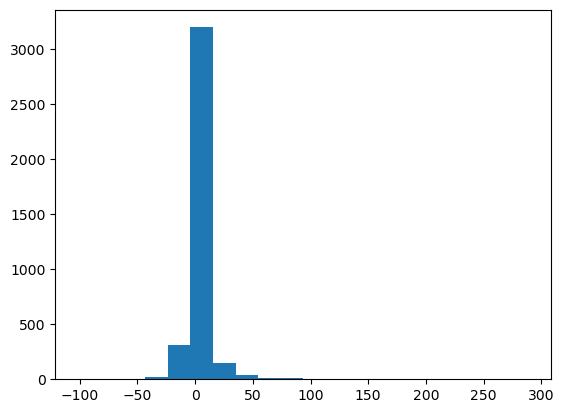

In [724]:
plt.hist(x=ndf.loc[ndf.target=='UPDATE_AD_GROUP_TARGET_CPA_DOWN']['profit'],bins=20)

In [8]:
ndf = ndf.loc[ndf.target!='UPDATE_CAMPAIGN_BUDGET_AMOUNT'].reset_index(drop=True)

In [11]:
cl = dict(zip(list(ndf['target'].value_counts().keys()), range(len(ndf['target'].value_counts()))))
cl

{'NO_CHANGE': 0,
 'UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP': 1,
 'UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN': 2,
 'STRATEGY_CPA': 3,
 'UPDATE_AD_GROUP_TARGET_CPA_UP': 4,
 'UPDATE_AD_GROUP_TARGET_CPA_DOWN': 5,
 'UPDATE_CAMPAIGN': 6,
 'STRATEGY_CONVERSION': 7}

In [210]:
#ndf.to_csv('dataset_final.csv', index=False)

In [6]:
ndf = pd.read_csv('dataset_final.csv')

In [7]:
ndf.columns

Index(['adgroup_id', 'date', 'impressions', 'bought', 'cost', 'sold', 'earned',
       'profit', 'max_cpa', 'max_cpc', 'campaign_budget_amount', 'rn',
       'is_max_conversion', 'target', 'cum_profit', 'cost_rate', 'profit_lag',
       'impressions_lag', 'profit_dif', 'profit_rate', 'impr_dynamic',
       'profit_cond', 'tgt_lag_NO_CHANGE', 'tgt_lag_STRATEGY_CONVERSION',
       'tgt_lag_STRATEGY_CPA', 'tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_DOWN',
       'tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_UP', 'tgt_lag_UPDATE_CAMPAIGN',
       'tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT',
       'tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN',
       'tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP', 'cpa_flag', 'impr_flag',
       'cost_rate_lag', 'cost_rate_dynamic', 'is_first_days'],
      dtype='object')

In [8]:
features = ['impressions', 'impr_dynamic', 'cpa_flag', 'impr_flag', 'bought', 'cost', 'sold', 
            'earned', 'profit', 'profit_cond', 'cost_rate', 'cost_rate_dynamic', 'profit_dif', 'profit_rate', 
            'cum_profit', 'max_cpa', 'max_cpc', 'rn', 'is_first_days', 'campaign_budget_amount', 'is_max_conversion',
       'tgt_lag_NO_CHANGE', 
       'tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_DOWN',
       'tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_UP',
       'tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN',
       'tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP', 'target']

In [9]:
ndf.loc[ndf.target == 'STRATEGY_CPA', 'is_max_conversion'] = 1
ndf.loc[ndf.target == 'MAXIMIZE_CONERSION', 'is_max_conversion'] = 0
ndf = ndf.loc[ndf.target!='UPDATE_CAMPAIGN_BUDGET_AMOUNT'].reset_index(drop=True)

In [12]:
def remove_short_adgroups(ndf, size):
    adg_dict = dict(ndf.adgroup_id.value_counts())
    adg_list = []
    for ad in adg_dict:
        if adg_dict[ad] > size:
            adg_list.append(ad)
    return ndf.loc[ndf['adgroup_id'].isin(adg_list)].reset_index(drop=True)

In [13]:
def get_validation_set(df, size):
    ad_list = random.sample(list(pd.unique(df.adgroup_id)), size)
    df = df.loc[df.adgroup_id.isin(ad_list)].reset_index(drop=True)
    return df[features[:-1]].astype(float), df['target'].apply(lambda x: cl[x]), df.loc[df.adgroup_id.isin(ad_list)]['adgroup_id'].reset_index(drop=True)

In [14]:
ndf = remove_short_adgroups(ndf, 3)
X_val, y_val, adf = get_validation_set(ndf, 100)

In [15]:
X = ndf[features[:-1]].astype(float)
y = ndf['target'].apply(lambda x: cl[x])

In [16]:
X[X.isna().any(axis=1)]

,impressions,impr_dynamic,cpa_flag,impr_flag,bought,cost,sold,earned,profit,profit_cond,...,max_cpc,rn,is_first_days,campaign_budget_amount,is_max_conversion,tgt_lag_NO_CHANGE,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_DOWN,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_UP,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP


In [17]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size= 0.2, random_state = 42, stratify=y)

In [18]:
X_train.head()

,impressions,impr_dynamic,cpa_flag,impr_flag,bought,cost,sold,earned,profit,profit_cond,...,max_cpc,rn,is_first_days,campaign_budget_amount,is_max_conversion,tgt_lag_NO_CHANGE,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_DOWN,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_UP,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
12958,17058.0,3.736,0.0,0.0,3860.0,83.18,374.0,204.5094,121.3294,1.0,...,0.01,35.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,1.0
14380,1887.0,0.342,0.0,1.0,319.0,10.98,49.0,37.6585,26.6785,1.0,...,0.01,46.0,0.0,21.0,0.0,0.0,0.0,1.0,0.0,0.0
38320,5998.0,0.002,1.0,0.0,687.0,40.19,248.0,32.7315,-7.4585,0.0,...,0.01,25.0,0.0,41.0,0.0,0.0,0.0,0.0,0.0,1.0
14397,9816.0,9.453,1.0,0.0,530.0,17.01,56.0,16.7657,-0.2443,0.0,...,0.01,8.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
2207,5638.0,1.869,1.0,0.0,257.0,11.25,77.0,13.5831,2.3331,0.0,...,0.00,214.0,0.0,21.0,0.0,1.0,0.0,0.0,0.0,0.0


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
torch.cuda.is_available()

True

In [21]:
class model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(model, self).__init__()
 #       self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.sigmoid = nn.Sigmoid()
        self.l2 = nn.Linear(hidden_size, hidden_size * 3) 
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(hidden_size * 3, hidden_size * 5) 
        self.tan = nn.ReLU()
        self.drop = nn.Dropout(0.1)
        self.l4 = nn.Linear(hidden_size * 5, hidden_size * 3) 
        self.relu = nn.ReLU()
        self.l5 = nn.Linear(hidden_size * 3, num_classes)   

    def forward(self, x):
        out = self.l1(x)
        out = self.sigmoid(out)
        out = self.l2(out)
        out = self.tan(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.l4(out)
        out = self.relu(out)
        out = self.l5(out)
        # no activation and no softmax at the end
        return out 

In [22]:
CUDA_LAUNCH_BLOCKING=1

In [23]:
md = model(26, 42, 8).to(device)

In [24]:
md

model(
  (l1): Linear(in_features=26, out_features=42, bias=True)
  (sigmoid): Sigmoid()
  (l2): Linear(in_features=42, out_features=126, bias=True)
  (relu): ReLU()
  (l3): Linear(in_features=126, out_features=210, bias=True)
  (tan): ReLU()
  (drop): Dropout(p=0.1, inplace=False)
  (l4): Linear(in_features=210, out_features=126, bias=True)
  (l5): Linear(in_features=126, out_features=8, bias=True)
)

In [25]:
pd.unique(y_test)

array([2, 0, 4, 1, 3, 5, 7, 6], dtype=int64)

In [247]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(md.parameters(), lr=0.0001) 

n_total_steps = len(X_train)
for epoch in range(200):
    for i in range(1, 50):  
        md.train()
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        
        data = torch.tensor(X_train.values, dtype = torch.float32)
        data = data.to(device)

        labels = torch.tensor(y_train.values)
        labels = labels.to(device)
        # Forward pass
        outputs = md(data)

        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

        if (epoch+1) % 10 == 0 and i == 49:
            print (f'Epoch [{epoch+1}/{100}], Step[{i+1}], Loss: {loss.item():.4f}') 

    with torch.no_grad():
        outs = md(torch.tensor(X_test.values, dtype = torch.float32).to(device))
        _, predicted = torch.max(outs, 1)
        pred = predicted.detach().cpu().numpy()
        if (epoch+1) % 10 == 0:
            print(f1_score(y_test, pred, average='weighted'))

Epoch [10/100], Step[50], Loss: 1.1860
0.4628799549177103
Epoch [20/100], Step[50], Loss: 1.0513
0.5227554774281165
Epoch [30/100], Step[50], Loss: 0.9769
0.56214582866974
Epoch [40/100], Step[50], Loss: 0.9092
0.5910302199811692
Epoch [50/100], Step[50], Loss: 0.8666
0.6038315961172591
Epoch [60/100], Step[50], Loss: 0.8441
0.6122735586547814
Epoch [70/100], Step[50], Loss: 0.8294
0.6168090509771849
Epoch [80/100], Step[50], Loss: 0.8184
0.6164940187449355
Epoch [90/100], Step[50], Loss: 0.8074
0.6206631322591251
Epoch [100/100], Step[50], Loss: 0.7969
0.6231432629139764
Epoch [110/100], Step[50], Loss: 0.7921
0.6232776698244431
Epoch [120/100], Step[50], Loss: 0.7814
0.6281382800143199
Epoch [130/100], Step[50], Loss: 0.7739
0.6288573027018619
Epoch [140/100], Step[50], Loss: 0.7681
0.6247801577889219
Epoch [150/100], Step[50], Loss: 0.7622
0.6312581928793363
Epoch [160/100], Step[50], Loss: 0.7593
0.6279327624632085
Epoch [170/100], Step[50], Loss: 0.7544
0.6263220825798322
Epoch [1

                                    precision    recall  f1-score   support

                         NO_CHANGE     0.6447    0.7980    0.7132      3897
  UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP     0.7197    0.7481    0.7336      2719
UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN     0.6746    0.4749    0.5574       598
                      STRATEGY_CPA     0.4873    0.2177    0.3009       441
     UPDATE_AD_GROUP_TARGET_CPA_UP     0.3843    0.1921    0.2562       458
   UPDATE_AD_GROUP_TARGET_CPA_DOWN     0.4091    0.0226    0.0428       399
                   UPDATE_CAMPAIGN     0.0000    0.0000    0.0000         5
               STRATEGY_CONVERSION     0.0000    0.0000    0.0000         6

                          accuracy                         0.6595      8523
                         macro avg     0.4150    0.3067    0.3255      8523
                      weighted avg     0.6367    0.6595    0.6306      8523

0.6306008255806654
[[3110  502   91   70  114    7    1    2]
 [ 639 2034    8   25  

<Axes: >

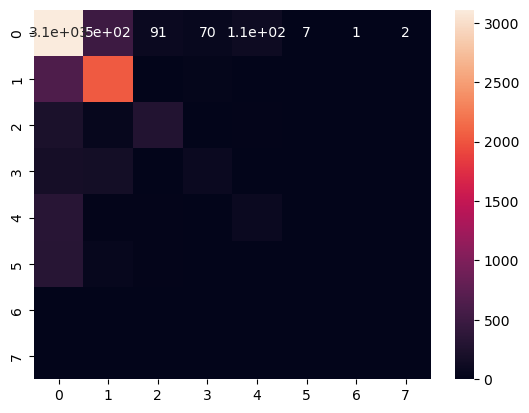

In [348]:
pred = predicted.detach().cpu().numpy()
print(classification_report(y_test, pred, target_names=cl.keys(), digits=4, zero_division=0))
print(f1_score(y_test, pred, average='weighted'))
cf = confusion_matrix(y_test, pred)
print(cf)
sns.heatmap(cf, annot=True)

In [26]:
def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key

In [41]:
md = my_model

In [42]:
with torch.no_grad():
    outs = md(torch.tensor(X.values, dtype = torch.float32).to(device))
    _, predicted_all = torch.max(outs, 1)
    preds = predicted_all.detach().cpu().numpy()
    print(f1_score(y, preds, average='weighted'))

fact= [get_key(x, cl) for x in y]
lbl = [get_key(x, cl) for x in preds]

0.6550174807532261


In [43]:
ndf['predicted'] = lbl
ndf['y_true'] = fact

In [44]:
with torch.no_grad():
    outs = md(torch.tensor(X_val.values, dtype = torch.float32).to(device))
    _, predicted_all = torch.max(outs, 1)
    preds = predicted_all.detach().cpu().numpy()
    print(f1_score(y_val, preds, average='weighted'))

fact= [get_key(x, cl) for x in y_val]
lbl = [get_key(x, cl) for x in preds]

0.6655335731305337


In [46]:
cl

{'NO_CHANGE': 0,
 'UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP': 1,
 'UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN': 2,
 'STRATEGY_CPA': 3,
 'UPDATE_AD_GROUP_TARGET_CPA_UP': 4,
 'UPDATE_AD_GROUP_TARGET_CPA_DOWN': 5,
 'UPDATE_CAMPAIGN': 6,
 'STRATEGY_CONVERSION': 7}

In [45]:
ndf.loc[ndf.y_true=='STRATEGY_CONVERSION']['adgroup_id']

4848      75707
5792      79305
9725      88244
11310     90192
11317     90194
12024     91426
13278     93560
13535     93739
13918     94738
15046     95776
15064     95776
15127     95777
15832     96727
16901     98698
20188    103569
20806    104292
22036    106407
24726    108513
24770    108518
25264    108765
25446    109073
26602    109871
28359    112367
29434    113648
30602    114812
30707    114994
30983    115327
31590    115954
35177    121107
37019    123434
37747    124182
Name: adgroup_id, dtype: int64

In [375]:
ndf.loc[ndf.adgroup_id == 75707]

,adgroup_id,date,impressions,bought,cost,sold,earned,profit,max_cpa,max_cpc,...,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,cpa_flag,impr_flag,cost_rate_lag,cost_rate_dynamic,is_first_days,predicted,y_true
4781,75707,2024-05-30,2609,169,7.03,46,14.4256,7.3956,5.00,0.01,...,0,0,1,0,0,0.910000,-0.094286,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
4782,75707,2024-05-31,2636,117,7.03,16,8.9780,1.9480,5.00,0.01,...,0,0,1,0,0,1.004286,0.000000,0,NO_CHANGE,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
4783,75707,2024-06-01,3228,150,9.85,51,21.4042,11.5542,5.00,0.01,...,0,0,1,0,0,1.004286,0.108831,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
4784,75707,2024-06-02,4641,257,10.32,82,29.6528,19.3328,5.00,0.01,...,0,0,1,0,0,0.895455,-0.042727,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,NO_CHANGE
4785,75707,2024-06-03,1985,72,3.80,11,5.6700,1.8700,5.00,0.01,...,0,0,0,0,0,0.938182,0.592727,0,NO_CHANGE,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4865,75707,2024-08-28,155,3,0.06,0,0.0000,-0.0600,0.23,0.01,...,0,1,0,1,0,0.002000,-0.006571,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN,UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN
4866,75707,2024-08-29,1405,62,1.46,8,2.8882,1.4282,0.23,0.01,...,0,1,0,0,0,0.008571,-0.200000,0,NO_CHANGE,UPDATE_AD_GROUP_TARGET_CPA_UP
4867,75707,2024-08-30,674,28,0.60,4,1.2191,0.6191,0.24,0.01,...,0,0,0,0,0,0.208571,0.122857,0,NO_CHANGE,NO_CHANGE
4868,75707,2024-08-31,498,18,0.39,1,0.2313,-0.1587,0.24,0.01,...,0,0,0,0,0,0.085714,0.030000,0,NO_CHANGE,NO_CHANGE


In [377]:
ndf.to_csv('data_final.csv', index=False)

In [370]:
ndf.loc[ndf.y_true=='STRATEGY_CPA']['adgroup_id']

11        25358
580       26855
693       35830
841       36696
1016      38117
          ...  
42416    131556
42420    131557
42444    131660
42496    131704
42596    131901
Name: adgroup_id, Length: 2206, dtype: int64

In [373]:
ndf.loc[ndf.adgroup_id == 25358][25:]

,adgroup_id,date,impressions,bought,cost,sold,earned,profit,max_cpa,max_cpc,...,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,cpa_flag,impr_flag,cost_rate_lag,cost_rate_dynamic,is_first_days,predicted,y_true
25,25358,2024-01-23,3614,140,13.07,42,31.4876,18.4176,0.34,0.01,...,0,0,0,0,1,0.304762,-0.006429,0,UPDATE_AD_GROUP_TARGET_CPA_UP,NO_CHANGE
26,25358,2024-01-24,5234,194,24.48,49,26.8711,2.3911,0.34,0.01,...,0,0,0,1,0,0.311190,-0.271667,0,NO_CHANGE,NO_CHANGE
27,25358,2024-01-25,12438,494,40.46,130,66.2999,25.8399,0.34,0.01,...,0,0,0,0,0,0.582857,-0.380476,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
28,25358,2024-01-26,15200,599,34.68,105,56.5893,21.9093,0.34,0.01,...,0,0,1,1,0,0.963333,0.283333,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
29,25358,2024-01-27,9702,495,49.30,145,64.1360,14.8360,0.34,0.01,...,0,0,1,0,1,0.680000,-0.286667,0,NO_CHANGE,NO_CHANGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,25358,2024-09-12,3882,179,5.89,37,13.6874,7.7974,0.22,0.01,...,0,0,1,0,1,0.462000,0.226400,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_AD_GROUP_TARGET_CPA_UP
251,25358,2024-09-13,4922,244,10.02,42,12.8267,2.8067,0.23,0.01,...,0,0,0,1,0,0.235600,-0.165200,0,NO_CHANGE,UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN
252,25358,2024-09-14,5596,318,23.46,74,5.5264,-17.9336,0.15,0.01,...,0,1,0,1,0,0.400800,-1.731927,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN,UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN
253,25358,2024-09-15,2314,125,4.95,30,2.9209,-2.0291,0.15,0.01,...,0,1,0,0,0,2.132727,1.425584,0,NO_CHANGE,UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN


In [ ]:
from sklearn import linear_model
import matplotlib.pyplot as plt

In [223]:
def get_next_day_state(df, adg, prev_state, prediction):
    dft = df.loc[df.adgroup_id == adg].reset_index(drop=True)
    reg = linear_model.LinearRegression()
    X, y = dft[['max_cpa','campaign_budget_amount', 'rn']], dft['impressions']
    print(X, y)
    reg.fit(X, y)
    pred = reg.predict(X)
    dft['pred'] = pred
    var = np.var(dft['impressions'] - dft['pred'])
    print(reg.coef_, var)

In [266]:
result = pd.concat([adf, X_val, pd.DataFrame(columns=['y_true'], data=fact), pd.DataFrame(columns=['predicted'], data=lbl)], axis=1)
result

,adgroup_id,impressions,impr_dynamic,cpa_flag,impr_flag,bought,cost,sold,earned,profit,...,is_first_days,campaign_budget_amount,is_max_conversion,tgt_lag_NO_CHANGE,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_DOWN,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_UP,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,y_true,predicted
0,78123,1.0,-0.730,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,...,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
1,78123,1541.0,1.540,0.0,0.0,48.0,3.4900,12.0,6.5799,3.0899,...,0.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
2,78123,2575.0,1.034,0.0,0.0,89.0,5.2500,12.0,4.9630,-0.2870,...,0.0,7.0,1.0,0.0,0.0,0.0,0.0,1.0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
3,78123,2190.0,-0.385,0.0,0.0,102.0,4.3900,28.0,7.1972,2.8072,...,0.0,7.0,1.0,0.0,0.0,0.0,0.0,1.0,NO_CHANGE,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
4,78123,3032.0,0.842,1.0,0.0,149.0,7.8500,20.0,9.2711,1.4211,...,0.0,7.0,1.0,1.0,0.0,0.0,0.0,0.0,NO_CHANGE,NO_CHANGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,131885,41.0,-0.814,0.0,0.0,4.0,0.1589,0.0,0.0000,-0.1589,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,NO_CHANGE,NO_CHANGE
1345,131901,321.0,0.211,0.0,0.0,9.0,0.8400,6.0,1.1015,0.2615,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NO_CHANGE,NO_CHANGE
1346,131901,57.0,-0.264,0.0,0.0,9.0,1.0100,2.0,0.3515,-0.6585,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,STRATEGY_CPA,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
1347,131901,552.0,0.495,0.0,0.0,38.0,3.0300,21.0,2.6017,-0.4283,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP


In [368]:
ndf[:40]

,adgroup_id,date,impressions,bought,cost,sold,earned,profit,max_cpa,max_cpc,...,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,cpa_flag,impr_flag,cost_rate_lag,cost_rate_dynamic,is_first_days,predicted,y_true
0,25358,2023-12-28,404,24,0.71,3,1.5408,0.8308,5.00,0.01,...,0,0,0,0,0,1.030000,0.793333,0,NO_CHANGE,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
1,25358,2023-12-29,4157,308,10.84,59,22.0487,11.2087,5.00,0.01,...,0,0,1,0,0,0.236667,-0.748788,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
2,25358,2023-12-30,3950,338,10.75,59,15.3252,4.5752,5.00,0.01,...,0,0,1,0,0,0.985455,0.008182,0,NO_CHANGE,NO_CHANGE
3,25358,2023-12-31,3865,255,11.18,50,8.1239,-3.0561,5.00,0.01,...,0,0,0,0,0,0.977273,-0.039091,0,STRATEGY_CPA,NO_CHANGE
4,25358,2024-01-01,3522,256,9.09,55,15.0385,5.9485,5.00,0.01,...,0,0,0,0,1,1.016364,0.190000,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,NO_CHANGE
5,25358,2024-01-02,4704,258,8.02,79,17.1045,9.0845,5.00,0.01,...,0,0,0,0,1,0.826364,0.097273,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,NO_CHANGE
6,25358,2024-01-03,2924,188,9.93,76,39.0409,29.1109,5.00,0.01,...,0,0,0,0,1,0.729091,-0.173636,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,NO_CHANGE
7,25358,2024-01-04,4397,253,10.40,79,22.4918,12.0918,5.00,0.01,...,0,0,0,1,1,0.902727,-0.042727,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
8,25358,2024-01-05,5094,279,11.37,66,32.4455,21.0755,5.00,0.01,...,0,0,1,0,1,0.945455,0.404026,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
9,25358,2024-01-06,11663,583,32.58,157,60.1598,27.5798,5.00,0.01,...,0,0,1,0,0,0.541429,-0.234286,0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP


In [343]:
result.loc[(result.is_max_conversion == 1) & (result.y_true == 'STRATEGY_CPA')]

,adgroup_id,impressions,impr_dynamic,cpa_flag,impr_flag,bought,cost,sold,earned,profit,...,is_first_days,campaign_budget_amount,is_max_conversion,tgt_lag_NO_CHANGE,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_DOWN,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_UP,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,y_true,predicted
19,78123,22990.0,-0.021,0.0,0.0,786.0,48.23,108.0,81.5062,33.2762,...,0.0,63.0,1.0,0.0,0.0,0.0,0.0,1.0,STRATEGY_CPA,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
47,80053,46623.0,20.859,1.0,0.0,1840.0,99.41,260.0,50.1826,-49.2274,...,0.0,65.0,1.0,1.0,0.0,0.0,0.0,0.0,STRATEGY_CPA,STRATEGY_CPA
79,86374,4373.0,3.917,0.0,0.0,409.0,10.85,83.0,12.7232,1.8732,...,0.0,11.0,1.0,0.0,0.0,0.0,0.0,1.0,STRATEGY_CPA,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
156,87164,15302.0,-7.211,0.0,0.0,562.0,18.75,36.0,7.6204,-11.1296,...,0.0,21.0,1.0,1.0,0.0,0.0,0.0,0.0,STRATEGY_CPA,STRATEGY_CPA
165,87595,1182.0,0.708,1.0,0.0,144.0,4.87,26.0,5.0079,0.1379,...,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,STRATEGY_CPA,NO_CHANGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320,130280,1016.0,-0.820,0.0,0.0,44.0,2.92,7.0,0.8820,-2.0380,...,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,STRATEGY_CPA,STRATEGY_CPA
1330,130663,1539.0,0.742,0.0,0.0,74.0,3.64,29.0,4.5868,0.9468,...,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,STRATEGY_CPA,STRATEGY_CPA
1334,131043,919.0,-0.101,0.0,0.0,70.0,6.29,19.0,3.8439,-2.4461,...,0.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,STRATEGY_CPA,STRATEGY_CPA
1338,131388,1013.0,-0.504,0.0,0.0,89.0,2.89,21.0,3.1476,0.2576,...,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,STRATEGY_CPA,NO_CHANGE


In [323]:
result[['adgroup_id', 'is_max_conversion', 'y_true']]

,adgroup_id,is_max_conversion,y_true
0,78123,1.0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
1,78123,1.0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
2,78123,1.0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
3,78123,1.0,NO_CHANGE
4,78123,1.0,NO_CHANGE
...,...,...,...
1344,131885,1.0,NO_CHANGE
1345,131901,1.0,NO_CHANGE
1346,131901,1.0,STRATEGY_CPA
1347,131901,0.0,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP


In [318]:
result.loc[result.is_max_conversion==0].loc[lambda x: x.y_true.str.contains('CPA')]

,adgroup_id,impressions,impr_dynamic,cpa_flag,impr_flag,bought,cost,sold,earned,profit,...,is_first_days,campaign_budget_amount,is_max_conversion,tgt_lag_NO_CHANGE,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_DOWN,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_UP,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,y_true,predicted
21,78123,19039.0,-13.253,0.0,0.0,651.0,30.17,140.0,41.0076,10.8376,...,0.0,63.0,0.0,1.0,0.0,0.0,0.0,0.0,UPDATE_AD_GROUP_TARGET_CPA_DOWN,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
31,78123,67278.0,31.290,1.0,0.0,2935.0,128.78,482.0,121.4542,-7.3258,...,0.0,111.0,0.0,0.0,0.0,0.0,0.0,1.0,UPDATE_AD_GROUP_TARGET_CPA_DOWN,NO_CHANGE
32,78123,51100.0,-16.178,0.0,0.0,2176.0,97.90,416.0,83.3202,-14.5798,...,0.0,111.0,0.0,0.0,1.0,0.0,0.0,0.0,UPDATE_AD_GROUP_TARGET_CPA_DOWN,NO_CHANGE
34,78123,63.0,-2.639,0.0,0.0,5.0,0.04,0.0,0.0000,-0.0400,...,0.0,111.0,0.0,1.0,0.0,0.0,0.0,0.0,UPDATE_AD_GROUP_TARGET_CPA_UP,NO_CHANGE
60,80053,105116.0,24.640,1.0,0.0,3993.0,136.57,534.0,148.5410,11.9710,...,0.0,141.0,0.0,0.0,0.0,0.0,0.0,1.0,UPDATE_AD_GROUP_TARGET_CPA_DOWN,NO_CHANGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,126732,25.0,-0.852,0.0,0.0,2.0,0.07,0.0,0.0000,-0.0700,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,UPDATE_AD_GROUP_TARGET_CPA_UP,NO_CHANGE
1285,127398,6.0,-0.024,0.0,0.0,0.0,0.00,0.0,0.0000,0.0000,...,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,UPDATE_AD_GROUP_TARGET_CPA_UP,NO_CHANGE
1286,127398,1.0,-0.005,0.0,0.0,0.0,0.00,0.0,0.0000,0.0000,...,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,UPDATE_AD_GROUP_TARGET_CPA_UP,UPDATE_AD_GROUP_TARGET_CPA_UP
1288,127398,3.0,-0.002,0.0,0.0,0.0,0.00,0.0,0.0000,0.0000,...,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,UPDATE_AD_GROUP_TARGET_CPA_UP,UPDATE_AD_GROUP_TARGET_CPA_UP


In [316]:
result.loc[result.is_max_conversion==1].loc[lambda x: x.y_true.str.contains('CPA')]

,adgroup_id,impressions,impr_dynamic,cpa_flag,impr_flag,bought,cost,sold,earned,profit,...,is_first_days,campaign_budget_amount,is_max_conversion,tgt_lag_NO_CHANGE,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_DOWN,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_UP,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,y_true,predicted
19,78123,22990.0,-0.021,0.0,0.0,786.0,48.23,108.0,81.5062,33.2762,...,0.0,63.0,1.0,0.0,0.0,0.0,0.0,1.0,STRATEGY_CPA,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
47,80053,46623.0,20.859,1.0,0.0,1840.0,99.41,260.0,50.1826,-49.2274,...,0.0,65.0,1.0,1.0,0.0,0.0,0.0,0.0,STRATEGY_CPA,STRATEGY_CPA
79,86374,4373.0,3.917,0.0,0.0,409.0,10.85,83.0,12.7232,1.8732,...,0.0,11.0,1.0,0.0,0.0,0.0,0.0,1.0,STRATEGY_CPA,UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP
156,87164,15302.0,-7.211,0.0,0.0,562.0,18.75,36.0,7.6204,-11.1296,...,0.0,21.0,1.0,1.0,0.0,0.0,0.0,0.0,STRATEGY_CPA,STRATEGY_CPA
165,87595,1182.0,0.708,1.0,0.0,144.0,4.87,26.0,5.0079,0.1379,...,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,STRATEGY_CPA,NO_CHANGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320,130280,1016.0,-0.820,0.0,0.0,44.0,2.92,7.0,0.8820,-2.0380,...,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,STRATEGY_CPA,STRATEGY_CPA
1330,130663,1539.0,0.742,0.0,0.0,74.0,3.64,29.0,4.5868,0.9468,...,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,STRATEGY_CPA,STRATEGY_CPA
1334,131043,919.0,-0.101,0.0,0.0,70.0,6.29,19.0,3.8439,-2.4461,...,0.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,STRATEGY_CPA,STRATEGY_CPA
1338,131388,1013.0,-0.504,0.0,0.0,89.0,2.89,21.0,3.1476,0.2576,...,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,STRATEGY_CPA,NO_CHANGE


In [271]:
acc = 0
is_two_sided = 0
for index, row in result.iterrows():
    pr, fct = row['predicted'], row['y_true']
    if is_two_sided:
        if pr in list(result['y_true'][index-2:index+2]):
            acc += 1
    else:
        if pr in list(result['y_true'][index:index+2]):
            acc += 1
print(acc/len(result))

0.7813194959229058


In [273]:
result.adgroup_id.value_counts()

adgroup_id
101228    91
96226     83
93421     76
86374     73
101168    66
          ..
117763     4
93640      4
118421     4
120043     4
131901     4
Name: count, Length: 100, dtype: int64

In [ ]:
#96226
#93421

In [281]:
result.to_csv('results.csv',index=False)

In [288]:
md.state_dict()

OrderedDict([('l1.weight',
              tensor([[ 1.4634e-03,  2.1426e-01, -3.7482e-01,  ...,  3.6652e-01,
                        2.8764e-01, -3.2136e-01],
                      [-5.9470e-02,  4.2487e-01, -2.9806e-01,  ...,  8.5222e-01,
                       -2.1823e-01,  1.4661e-01],
                      [-8.7295e-02, -2.3199e-01,  2.0808e-01,  ...,  2.0753e-01,
                       -1.5590e-01,  5.1315e-02],
                      ...,
                      [-1.6751e-05,  4.9149e-02,  6.7291e-02,  ...,  7.2303e-02,
                        5.0089e-02,  3.9713e-01],
                      [-2.6645e-04,  3.3962e-01, -4.0256e-01,  ...,  5.5180e-02,
                       -7.7685e-01, -5.0587e-02],
                      [-8.5924e-04,  6.3598e-01, -1.4562e-01,  ..., -1.7823e-01,
                       -1.1946e-01, -5.3687e-01]], device='cuda:0')),
             ('l1.bias',
              tensor([-0.1998,  0.5783, -0.3934, -0.1776,  0.3593,  0.3086, -0.3137,  0.1684,
                     

In [296]:
torch.save(md.state_dict(), 'model/model.pth')

In [299]:
md

model(
  (l1): Linear(in_features=26, out_features=42, bias=True)
  (sigmoid): Sigmoid()
  (l2): Linear(in_features=42, out_features=126, bias=True)
  (relu): ReLU()
  (l3): Linear(in_features=126, out_features=210, bias=True)
  (tan): ReLU()
  (drop): Dropout(p=0.1, inplace=False)
  (l4): Linear(in_features=210, out_features=126, bias=True)
  (l5): Linear(in_features=126, out_features=8, bias=True)
)

In [27]:
my_model = model(26, 42, 8).to(device)
my_model.load_state_dict(torch.load('model/model.pth'))
#weights = torch.load('model/model.pth', weights_only=True),

<All keys matched successfully>

In [28]:
my_model

model(
  (l1): Linear(in_features=26, out_features=42, bias=True)
  (sigmoid): Sigmoid()
  (l2): Linear(in_features=42, out_features=126, bias=True)
  (relu): ReLU()
  (l3): Linear(in_features=126, out_features=210, bias=True)
  (tan): ReLU()
  (drop): Dropout(p=0.1, inplace=False)
  (l4): Linear(in_features=210, out_features=126, bias=True)
  (l5): Linear(in_features=126, out_features=8, bias=True)
)

In [608]:
ndf.loc[ndf.rn.isin([1,2,3])]['target'].value_counts()

target
NO_CHANGE                             9496
UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP      8108
UPDATE_AD_GROUP_TARGET_CPA_DOWN        563
UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN      21
UPDATE_AD_GROUP_TARGET_CPA_UP           16
Name: count, dtype: int64

In [29]:
pred = predicted.detach().cpu().numpy()
print(classification_report(y_test, pred, target_names=cl.keys(), digits=4, zero_division=0))
print(f1_score(y_test, pred, average='weighted'))
cf = confusion_matrix(y_test, pred)
print(cf)
sns.heatmap(cf, annot=True)

NameError: name 'predicted' is not defined

In [610]:
print(classification_report(y_test, pred, target_names=cl.keys(), digits=4, zero_division=0))

                                    precision    recall  f1-score   support

                         NO_CHANGE     0.6847    0.7679    0.7240      5809
  UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP     0.6787    0.7323    0.7045      3605
   UPDATE_AD_GROUP_TARGET_CPA_DOWN     0.2477    0.0690    0.1079       768
UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN     0.4178    0.2832    0.3376       565
     UPDATE_AD_GROUP_TARGET_CPA_UP     0.2545    0.1179    0.1612       475

                          accuracy                         0.6567     11222
                         macro avg     0.4567    0.3941    0.4070     11222
                      weighted avg     0.6212    0.6567    0.6323     11222



In [913]:
print(classification_report(y_test, pred, target_names=cl.keys(), digits=4, zero_division=0))

                                     precision    recall  f1-score   support

                                END     1.0000    1.0000    1.0000     46264
                          NO_CHANGE     0.5662    0.7563    0.6476      3295
UPDATE_CAMPAIGN_BUDGET_AMOUNT_>1.25     0.5809    0.6504    0.6137      2031
  UPDATE_CAMPAIGN_BUDGET_AMOUNT_0.8     0.5106    0.1171    0.1905       410
    UPDATE_AD_GROUP_TARGET_CPA_1.25     0.4884    0.0538    0.0970       390
       UPDATE_AD_GROUP_TARGET_CPA_1     0.0000    0.0000    0.0000       330
 UPDATE_CAMPAIGN_BUDGET_AMOUNT_1.25     0.4519    0.5523    0.4971       306
    UPDATE_AD_GROUP_TARGET_CPA_0.25     0.0000    0.0000    0.0000       213
     UPDATE_AD_GROUP_TARGET_CPA_0.8     0.0000    0.0000    0.0000       130
 UPDATE_CAMPAIGN_BUDGET_AMOUNT_0.25     0.0000    0.0000    0.0000        68
    UPDATE_CAMPAIGN_BUDGET_AMOUNT_1     0.0000    0.0000    0.0000         9
   UPDATE_AD_GROUP_TARGET_CPA_>1.25     0.0000    0.0000    0.0000         

In [ ]:
                                precision    recall  f1-score   support

                                END     1.0000    1.0000    1.0000    231320
                          NO_CHANGE     0.5269    0.8292    0.6444     16476
UPDATE_CAMPAIGN_BUDGET_AMOUNT_>1.25     0.5767    0.5688    0.5727     10154
  UPDATE_CAMPAIGN_BUDGET_AMOUNT_0.8     0.0000    0.0000    0.0000      2049
    UPDATE_AD_GROUP_TARGET_CPA_1.25     0.0000    0.0000    0.0000      1950
       UPDATE_AD_GROUP_TARGET_CPA_1     0.0000    0.0000    0.0000      1649
 UPDATE_CAMPAIGN_BUDGET_AMOUNT_1.25     0.0000    0.0000    0.0000      1531
    UPDATE_AD_GROUP_TARGET_CPA_0.25     0.0000    0.0000    0.0000      1066
     UPDATE_AD_GROUP_TARGET_CPA_0.8     0.0000    0.0000    0.0000       648
 UPDATE_CAMPAIGN_BUDGET_AMOUNT_0.25     0.0000    0.0000    0.0000       340
    UPDATE_CAMPAIGN_BUDGET_AMOUNT_1     0.0000    0.0000    0.0000        46
   UPDATE_AD_GROUP_TARGET_CPA_>1.25     0.0000    0.0000    0.0000        35

                           accuracy                         0.9382    267264
                          macro avg     0.1753    0.1998    0.1848    267264
                       weighted avg     0.9199    0.9382    0.9270    267264

# PATH 2

In [10]:
df = pd.read_csv('dataset_less_classes.csv')

In [11]:
df = adapt_dataset(df, 64)

  0%|                                                                                         | 0/6686 [00:00<?, ?it/s]C:\Users\croxw\AppData\Local\Temp\ipykernel_17852\2258300960.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, temp_df.reset_index(drop=True)[:n] ])
100%|██████████████████████████████████████████████████████████████████████████████| 6686/6686 [02:33<00:00, 43.45it/s]


In [268]:
df.event_type.value_counts()
df["event_lagged"] = df.event_type.shift(1)
df['target'] = df['cat'].combine_first(df['event_type'])
ndf = df.loc[~( ((df.event_type == 'CREATE_AD_GROUP') | (df.event_type == 'CREATE_CAMPAIGN_CRITERION_AD_SCHEDULE') | (df.event_type == 'UPDATE_AD_GROUP_STATUS')) | ((df.event_type == 'UPDATE_AD_GROUP_STATUS') & (df.event_lagged == 'CREATE_AD_GROUP')) | (df.event_type == 'CREATE_AD_GROUP') )][['adgroup_id', 'date', 'impressions', 'bought', 'cost', 'sold', 'earned', 'profit', 'max_cpa', 'max_cpc', 'campaign_budget_amount', 'rn', 'target']].drop_duplicates().reset_index(drop=True)#, 'old_value', 'new_value']]
ndf = ndf.loc[ndf.target!='UPDATE_CAMPAIGN_BUDGET_AMOUNT'].reset_index(drop=True)
#ndf = ndf.dropna()
ndf['cum_profit'] = ndf.groupby('adgroup_id')['profit'].cumsum()
ndf['cost_rate'] = ndf['cost'] / ndf['campaign_budget_amount']
shifted = ndf.groupby("adgroup_id")['profit'].shift(1)
shifted_impr = ndf.groupby("adgroup_id")['impressions'].shift(1)
shifted_tgt= ndf.groupby("adgroup_id")['target'].shift(1)
#ndf['impr'] = np.log(ndf['impressions'])
ndf['profit_lag'] = shifted
ndf['impressions_lag'] = shifted_impr
ndf['tgt_lag'] = shifted_tgt
ndf['profit_dif'] = (ndf['profit'] - ndf['profit_lag']) / (ndf['cum_profit'])
ndf['profit_rate'] = ndf['profit'] / ndf['cum_profit']
ndf['impr_dynamic'] = (ndf['impressions'] - ndf['impressions_lag']) / 1e3
ndf['profit_dif'] = ndf['profit_dif'].fillna(0.15)
ndf['impr_dynamic'] = ndf['impr_dynamic'].fillna(0.01)
ndf['profit_cond'] = ndf['profit'].apply(lambda x: 1 if x > 15 else 0)

ndf = pd.get_dummies(ndf, columns=['tgt_lag'], dtype=int)

def mark_cpa(a,b,c):
    return 1 if a<0 and b>0 and c>5 else 0
def mark_impr(a,b,c):
    return 1 if a<10000 and b>5 and c>5 else 0

ndf['cpa_flag'] = ndf.apply(lambda x: mark_cpa(x['profit_dif'], x['impr_dynamic'], x['rn']), axis=1)
ndf['impr_flag'] = ndf.apply(lambda x: mark_impr(x['impressions'], x['profit'], x['rn']), axis=1)

shifted_costrate = ndf.groupby("adgroup_id")['cost_rate'].shift(1)
ndf['cost_rate_lag'] = shifted_costrate
ndf['cost_rate_dynamic'] = ndf['cost_rate_lag'] - ndf['cost_rate']
ndf['cost_rate_dynamic'] = ndf['cost_rate_dynamic'].fillna(0.15)
ndf['cost_rate_lag'] = ndf['cost_rate_lag'].fillna(0)

ind = ndf.loc[ndf.rn.isin([1,2,3])].index
ndf['is_first_days'] = 0
ndf.loc[ndf.index.isin(ind)]['is_first_days'] = 1
ndf = ndf.fillna(0)
#ndf = ndf.dropna().reset_index(drop=True)

C:\Users\croxw\AppData\Local\Temp\ipykernel_13524\805505673.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ndf['impr_dynamic'] = ndf['impr_dynamic'].fillna(0.01)
C:\Users\croxw\AppData\Local\Temp\ipykernel_13524\805505673.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf.loc[ndf.index.isin(ind)]['is_first_days'] = 1
C:\Users\croxw\AppData\Local\Temp\ipykernel_13524\805505673.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.i

In [271]:
lst = []
dct = dict(ndf['adgroup_id'].value_counts())
for adg in dct:
    if dct[adg]==64:
        lst.append(adg)
tdf = ndf.loc[ndf['adgroup_id'].isin(lst)].reset_index(drop=True)

In [272]:
cls = dict(zip(list(tdf['target'].value_counts().keys()), range(len(tdf['target'].value_counts()))))
cls

{'END': 0,
 'NO_CHANGE': 1,
 'UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP': 2,
 'UPDATE_AD_GROUP_TARGET_CPA_DOWN': 3,
 'UPDATE_AD_GROUP_TARGET_CPA_UP': 4,
 'UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN': 5}

In [292]:
def split_due_rate(X, rate=0.8):
    features = X.columns
    adg_list = list(pd.unique(X['adgroup_id']))
    adgs_train = list(random.sample(adg_list, int(rate * len(adg_list))))
    adgs_test = list(set(adg_list).difference(set(adgs_train)))
    print(X.loc[X.adgroup_id.isin(adgs_train)].profit.sum(), X.loc[X.adgroup_id.isin(adgs_test)].profit.sum())
    return X.loc[X.adgroup_id.isin(adgs_train)][features[:-1]], X.loc[X.adgroup_id.isin(adgs_test)][features[:-1]], \
        X.loc[X.adgroup_id.isin(adgs_train)]['target'].apply(lambda x: cls[x]), \
        X.loc[X.adgroup_id.isin(adgs_test)]['target'].apply(lambda x: cls[x])

In [274]:
X_tr.columns

Index(['adgroup_id', 'date', 'impressions', 'bought', 'cost', 'sold', 'earned',
       'profit', 'max_cpa', 'max_cpc', 'campaign_budget_amount', 'rn',
       'target', 'cum_profit', 'cost_rate', 'profit_lag', 'impressions_lag',
       'profit_dif', 'profit_rate', 'impr_dynamic', 'profit_cond',
       'tgt_lag_END', 'tgt_lag_NO_CHANGE',
       'tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_DOWN',
       'tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_UP',
       'tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN',
       'tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP', 'cpa_flag', 'impr_flag',
       'cost_rate_lag', 'cost_rate_dynamic'],
      dtype='object')

In [275]:
X_tr

,adgroup_id,date,impressions,bought,cost,sold,earned,profit,max_cpa,max_cpc,...,tgt_lag_END,tgt_lag_NO_CHANGE,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_DOWN,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_UP,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,cpa_flag,impr_flag,cost_rate_lag,cost_rate_dynamic
128,74273,2024-05-22,148,7,1.17,1,0.1382,-1.0318,5.00,0.01,...,0,0,0,0,0,0,0,0,NaN,0.150000
129,74273,2024-05-23,55,7,0.30,2,0.5661,0.2661,5.00,0.01,...,0,0,0,0,0,1,0,0,1.170000,1.070000
130,74273,2024-05-24,1611,163,4.07,32,9.3814,5.3114,5.00,0.01,...,0,0,0,0,0,1,0,0,0.100000,-0.481429
131,74273,2024-05-25,3549,289,9.14,58,12.9021,3.7621,5.00,0.01,...,0,0,0,0,0,1,0,0,0.581429,-0.249481
132,74273,2024-05-26,4178,333,10.37,63,13.3163,2.9463,0.15,0.01,...,0,0,0,0,0,1,0,0,0.830909,-0.111818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372859,127674,9999-12-31,0,0,0.00,0,0.0000,0.0000,0.00,0.00,...,1,0,0,0,0,0,0,0,NaN,0.150000
372860,127674,9999-12-31,0,0,0.00,0,0.0000,0.0000,0.00,0.00,...,1,0,0,0,0,0,0,0,NaN,0.150000
372861,127674,9999-12-31,0,0,0.00,0,0.0000,0.0000,0.00,0.00,...,1,0,0,0,0,0,0,0,NaN,0.150000
372862,127674,9999-12-31,0,0,0.00,0,0.0000,0.0000,0.00,0.00,...,1,0,0,0,0,0,0,0,NaN,0.150000


In [276]:
feat = ['impressions', 'bought', 'cost', 'sold', 'earned',
       'profit', 'max_cpa', 'max_cpc', 'campaign_budget_amount', 'rn',
       'cum_profit', 'cost_rate', 'profit_lag', 'impressions_lag',
       'profit_dif', 'profit_rate', 'impr_dynamic', 'profit_cond',
       'tgt_lag_END', 'tgt_lag_NO_CHANGE',
       'tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_DOWN',
       'tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_UP',
       'tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN',
       'tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP', 'cpa_flag', 'impr_flag',
       'cost_rate_lag', 'cost_rate_dynamic', 'target']

In [296]:
X_tr, X_t, y_tr, y_t = split_due_rate(tdf, rate=0.8)

-5453.7448 -1136.6903999999997


,impressions,bought,cost,sold,earned,profit,max_cpa,max_cpc,campaign_budget_amount,rn,...,tgt_lag_END,tgt_lag_NO_CHANGE,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_DOWN,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_UP,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,cpa_flag,impr_flag,cost_rate_lag,cost_rate_dynamic
0,215.0,9.0,1.31,0.0,0.0000,-1.3100,5.0,0.01,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.15
1,356.0,19.0,0.84,5.0,0.5467,-0.2933,5.0,0.01,1.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.31,0.47
2,527.0,23.0,0.68,7.0,0.9754,0.2954,5.0,0.01,1.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.84,0.16
3,452.0,22.0,0.71,3.0,0.3231,-0.3869,5.0,0.01,1.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.68,-0.03
4,565.0,45.0,1.26,14.0,2.2183,0.9583,5.0,0.01,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.71,0.29


In [657]:
class LSTM(nn.Module):
    
    def __init__(self,input_size = 28, hidden_size = 50, num_layers=5, out_size = 6):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size,out_size)
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        out = self.linear(lstm_out.flatten(1))
        return out
        #pred = self.linear(lstm_out.view(len(seq),-1))
        #return pred[-1]

In [658]:
model = LSTM()

In [659]:
data = torch.tensor(X_tr[feat[:-1]][:5].astype(float).values, dtype = torch.float32)
#data = data.to(device)
data

tensor([[ 2.1500e+02,  9.0000e+00,  1.3100e+00,  0.0000e+00,  0.0000e+00,
         -1.3100e+00,  5.0000e+00,  1.0000e-02,  1.0000e+00,  1.0000e+00,
         -1.3100e+00,  1.3100e+00,  0.0000e+00,  0.0000e+00,  1.5000e-01,
          1.0000e+00,  1.0000e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  1.5000e-01],
        [ 3.5600e+02,  1.9000e+01,  8.4000e-01,  5.0000e+00,  5.4670e-01,
         -2.9330e-01,  5.0000e+00,  1.0000e-02,  1.0000e+00,  2.0000e+00,
         -1.6033e+00,  8.4000e-01, -1.3100e+00,  2.1500e+02, -6.3413e-01,
          1.8294e-01,  1.4100e-01,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  1.3100e+00,  4.7000e-01],
        [ 5.2700e+02,  2.3000e+01,  6.8000e-01,  7.0000e+00,  9.7540e-01,
          2.9540e-01,  5.0000e+00,  1.0000e-02,  1.0000e+00,  3.0000e+00,
         -1.30


with torch.no_grad():        
    model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
    for adg in tqdm.tqdm(pd.unique(X_t['adgroup_id'])[:10]):
        for k in range(59):
            t = X_t.loc[X_t['adgroup_id']==adg][feat[:-1]][k:k+1]
            tind = X_t.loc[X_t['adgroup_id']==adg].index
            tind = tind[k+5]
            tseq = torch.tensor(t.values, dtype = torch.float32)
            preds.append( torch.max(model(tseq), 1)[1].detach().cpu().numpy()[0] )
            y_true.append(y_t.loc[y_t.index == tind].values[0]) 
    #        pred = predicted.detach().cpu().numpy()
        if (epoch+1) % 10 == 0:
            print(f1_score(y_true, preds, average='weighted'))


In [662]:
epochs = 5
future = 5
BATCH_SIZE = 64

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
res = []
preds = []
y_true = []
for i in range(epochs):
    ln = int(len(pd.unique(X_tr['adgroup_id'])) / BATCH_SIZE) + 1 

    for iters in tqdm.tqdm(range(ln)):
        ad = pd.unique(X_tr['adgroup_id'])[iters * BATCH_SIZE : (iters + 1) * BATCH_SIZE]

        for j in range(64):
            tr = X_tr.loc[(X_tr['adgroup_id'].isin(ad)) & (X_tr.rn == j+1)][feat[:-1]]
      #      ind = X_tr.loc[(X_tr['adgroup_id'].isin(ad)) & (X_tr.rn >= j) & (X_tr.rn <= j+2)].index
            indexes = X_tr.loc[(X_tr['adgroup_id'].isin(ad)) & (X_tr.rn == j+1)].index

            seq = torch.tensor(tr.values, dtype = torch.float32)
            print(seq.shape)
            optimizer.zero_grad()
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                           torch.zeros(1,1,model.hidden_size))

            y_pred = model(seq)

            labels = torch.tensor(y_tr.loc[y_tr.index.isin(indexes)].values)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()

    print(f"Epoch {i} Loss: {loss.item()}")

with torch.no_grad():
    model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size)) 
    for adg in tqdm.tqdm(pd.unique(X_t['adgroup_id'])): 
        for k in range(64): 
            t = X_t.loc[(X_t['adgroup_id']==adg)&(X_t['rn']==k+1)][feat[:-1]] 
            tind = X_t.loc[(X_t['adgroup_id']==adg)&(X_t['rn']==k+1)].index 
          #  tind = tind[k+5] 
            tseq = torch.tensor(t.values, dtype = torch.float32) 
            preds.append( torch.max(model(tseq), 1)[1].detach().cpu().numpy()[0] ) 
            y_true.append(y_t.loc[y_t.index == tind].values[0]) 
            # pred = predicted.detach().cpu().numpy() if (epoch+1) % 10 == 0: print(f1_score(y_true, preds, average='weighted'))


  0%|                                                                                           | 0/73 [00:00<?, ?it/s]

torch.Size([66, 28])
torch.Size([64, 28])
torch.Size([68, 28])
torch.Size([80, 28])
torch.Size([75, 28])
torch.Size([71, 28])
torch.Size([67, 28])
torch.Size([67, 28])
torch.Size([65, 28])
torch.Size([67, 28])
torch.Size([65, 28])
torch.Size([66, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([65, 28])
torch.Size([65, 28])
torch.Size([64, 28])
torch.Size([66, 28])
torch.Size([64, 28])
torch.Size([65, 28])
torch.Size([65, 28])
torch.Size([65, 28])
torch.Size([65, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([65, 28])
torch.Size([64, 28])
torch.Size([63, 28])
torch.Size([64, 28])
torch.Size([65, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([65, 28])
torch.Size([65, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([65, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([6

  1%|█▏                                                                                 | 1/73 [00:00<00:32,  2.23it/s]

torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([63, 28])
torch.Size([62, 28])
torch.Size([1, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([71, 28])
torch.Size([69, 28])
torch.Size([76, 28])
torch.Size([74, 28])
torch.Size([67, 28])
torch.Size([70, 28])
torch.Size([66, 28])
torch.Size([68, 28])
torch.Size([64, 28])
torch.Size([65, 28])
torch.Size([66, 28])
torch.Size([66, 28])
torch.Size([64, 28])
torch.Size([67, 28])
torch.Size([65, 28])
torch.Size([67, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([66, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([65, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64

  1%|█▏                                                                                 | 1/73 [00:00<01:03,  1.13it/s]

torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([64, 28])
torch.Size([0, 28])


RuntimeError: cannot reshape tensor of 0 elements into shape [0, 1, -1] because the unspecified dimension size -1 can be any value and is ambiguous

In [619]:
pd.unique(X_t['adgroup_id'])[:10]

array([75269, 80777, 84536, 85815, 86485, 86487, 87166, 87168, 87477,
       87941], dtype=int64)

In [620]:
X_t.loc[X_t.adgroup_id.isin([75269, 80777, 84536, 85815, 86485, 86487, 87166, 87168, 87477, 87941])]

,adgroup_id,date,impressions,bought,cost,sold,earned,profit,max_cpa,max_cpc,...,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_DOWN,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_UP,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,cpa_flag,impr_flag,cost_rate_lag,cost_rate_dynamic,pred_lbl,fact_lbl
256,75269,2024-05-26,383,5,1.08,1,0.1514,-0.9286,5.0,0.01,...,0,0,0,0,0,0,0.000,0.150,,
257,75269,2024-05-27,143,9,0.41,1,0.0329,-0.3771,5.0,0.01,...,0,0,0,1,0,0,1.080,0.875,,
258,75269,2024-05-28,1046,67,3.11,16,1.7510,-1.3590,5.0,0.01,...,0,0,0,1,0,0,0.205,-1.350,,
259,75269,2024-05-29,943,74,2.35,12,2.7848,0.4348,5.0,0.01,...,0,0,0,0,0,0,1.555,0.380,,
260,75269,2024-05-29,943,74,2.35,12,2.7848,0.4348,5.0,0.01,...,0,0,0,1,0,0,1.175,0.000,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,87941,9999-12-31,0,0,0.00,0,0.0000,0.0000,0.0,0.00,...,0,0,0,0,0,0,0.000,0.150,,
4028,87941,9999-12-31,0,0,0.00,0,0.0000,0.0000,0.0,0.00,...,0,0,0,0,0,0,0.000,0.150,,
4029,87941,9999-12-31,0,0,0.00,0,0.0000,0.0000,0.0,0.00,...,0,0,0,0,0,0,0.000,0.150,,
4030,87941,9999-12-31,0,0,0.00,0,0.0000,0.0000,0.0,0.00,...,0,0,0,0,0,0,0.000,0.150,,


In [621]:
y_true_1 = []
preds_1 = []
for x in range(10):
    y_true_1.extend([np.NaN] * 5)
    y_true_1.extend(y_true[x*59:(x+1)*59])
    preds_1.extend([np.NaN] * 5)
    preds_1.extend(preds[x*59:(x+1)*59])

In [622]:
rdf = X_t.loc[X_t.adgroup_id.isin([75269, 80777, 84536, 85815, 86485, 86487, 87166, 87168, 87477, 87941])]

In [623]:
rdf['pred_lbl'] = preds_1
rdf['fact_lbl'] = y_true_1

C:\Users\croxw\AppData\Local\Temp\ipykernel_13524\2231218519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['pred_lbl'] = preds_1
C:\Users\croxw\AppData\Local\Temp\ipykernel_13524\2231218519.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['fact_lbl'] = y_true_1


In [624]:
rdf.loc[rdf.fact_lbl != rdf.pred_lbl]

,adgroup_id,date,impressions,bought,cost,sold,earned,profit,max_cpa,max_cpc,...,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_DOWN,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_UP,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,cpa_flag,impr_flag,cost_rate_lag,cost_rate_dynamic,pred_lbl,fact_lbl
256,75269,2024-05-26,383,5,1.08,1,0.1514,-0.9286,5.00,0.01,...,0,0,0,0,0,0,0.000,0.150,NaN,NaN
257,75269,2024-05-27,143,9,0.41,1,0.0329,-0.3771,5.00,0.01,...,0,0,0,1,0,0,1.080,0.875,NaN,NaN
258,75269,2024-05-28,1046,67,3.11,16,1.7510,-1.3590,5.00,0.01,...,0,0,0,1,0,0,0.205,-1.350,NaN,NaN
259,75269,2024-05-29,943,74,2.35,12,2.7848,0.4348,5.00,0.01,...,0,0,0,0,0,0,1.555,0.380,NaN,NaN
260,75269,2024-05-29,943,74,2.35,12,2.7848,0.4348,5.00,0.01,...,0,0,0,1,0,0,1.175,0.000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,87941,2024-08-21,604,27,0.47,2,0.1094,-0.3606,0.14,0.01,...,0,0,0,0,0,0,0.000,-0.094,0.0,1.0
3979,87941,2024-08-22,4,0,0.00,0,0.0000,0.0000,0.14,0.01,...,0,0,0,0,0,0,0.094,0.094,0.0,1.0
3980,87941,2024-08-25,1,0,0.00,0,0.0000,0.0000,0.14,0.01,...,0,0,0,0,0,0,0.000,0.000,0.0,1.0
3981,87941,2024-08-29,1,0,0.00,0,0.0000,0.0000,0.14,0.01,...,0,0,0,0,0,0,0.000,0.000,0.0,1.0


In [612]:
X_t

,adgroup_id,date,impressions,bought,cost,sold,earned,profit,max_cpa,max_cpc,...,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_DOWN,tgt_lag_UPDATE_AD_GROUP_TARGET_CPA_UP,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_DOWN,tgt_lag_UPDATE_CAMPAIGN_BUDGET_AMOUNT_UP,cpa_flag,impr_flag,cost_rate_lag,cost_rate_dynamic,pred_lbl,fact_lbl
256,75269,2024-05-26,383,5,1.08,1,0.1514,-0.9286,5.0,0.01,...,0,0,0,0,0,0,0.000,0.150,,
257,75269,2024-05-27,143,9,0.41,1,0.0329,-0.3771,5.0,0.01,...,0,0,0,1,0,0,1.080,0.875,,
258,75269,2024-05-28,1046,67,3.11,16,1.7510,-1.3590,5.0,0.01,...,0,0,0,1,0,0,0.205,-1.350,,
259,75269,2024-05-29,943,74,2.35,12,2.7848,0.4348,5.0,0.01,...,0,0,0,0,0,0,1.555,0.380,,
260,75269,2024-05-29,943,74,2.35,12,2.7848,0.4348,5.0,0.01,...,0,0,0,1,0,0,1.175,0.000,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372731,127672,9999-12-31,0,0,0.00,0,0.0000,0.0000,0.0,0.00,...,0,0,0,0,0,0,0.000,0.150,,
372732,127672,9999-12-31,0,0,0.00,0,0.0000,0.0000,0.0,0.00,...,0,0,0,0,0,0,0.000,0.150,,
372733,127672,9999-12-31,0,0,0.00,0,0.0000,0.0000,0.0,0.00,...,0,0,0,0,0,0,0.000,0.150,,
372734,127672,9999-12-31,0,0,0.00,0,0.0000,0.0000,0.0,0.00,...,0,0,0,0,0,0,0.000,0.150,,


In [ ]:
 """   
    preds = train_set[-window_size:].tolist()
    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                           torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
        
    loss = criterion(torch.tensor(preds[-window_size:]), y[760:])
    print(f"Performance on test range: {loss}")
    
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy(),color='#8000ff')
    plt.plot(range(760,800),preds[window_size:],color='#ff8000')
    plt.show()
    """

In [346]:
rnn = nn.LSTM(10, 20, 2)
input = torch.randn(6, 1, 10)
h0 = torch.randn(2, 1, 20)
c0 = torch.randn(2, 1, 20)
output, (hn, cn) = rnn(input, (h0, c0))
t = nn.Linear(20, 1)
t(output).flatten()

tensor([0.0174, 0.0427, 0.0425, 0.0387, 0.0327, 0.0230],
       grad_fn=<ViewBackward0>)

In [324]:
output.shape

torch.Size([5, 3, 20])

In [323]:
output

tensor([[[ 3.1426e-01,  2.6015e-01,  3.4374e-01,  4.4945e-01,  2.5957e-01,
          -2.8263e-01, -1.0358e-01, -2.1358e-01,  2.4288e-02, -2.6190e-01,
          -3.8028e-02,  3.3039e-01,  3.6986e-02, -1.0491e-01,  2.7513e-01,
           8.4147e-02, -1.9692e-01,  1.6713e-01, -1.5015e-01,  1.6240e-01],
         [ 4.7010e-01, -2.2419e-01,  3.4948e-01,  8.4693e-02,  8.2791e-02,
          -4.5870e-01, -3.6180e-02, -8.0485e-02, -2.0636e-01, -1.9824e-01,
          -5.5040e-01, -1.3576e-01,  2.5651e-01,  2.3276e-01, -3.2699e-02,
           2.9434e-01, -1.0403e-01, -4.2055e-01, -1.7784e-01,  1.4707e-02],
         [ 5.0686e-01,  2.1283e-01, -2.9633e-01,  6.5023e-02, -8.2957e-02,
           1.0989e-01,  1.6202e-01,  8.7133e-03,  2.7197e-01,  4.1416e-01,
           1.7247e-02, -3.9356e-01, -2.1946e-01, -1.5103e-01, -2.4293e-01,
          -2.6609e-01, -7.4481e-02, -3.0302e-01, -1.9935e-01,  5.5424e-01]],

        [[ 1.2814e-01,  2.4935e-01,  2.8250e-01,  2.6795e-01,  1.2929e-01,
          -1.3009e-0

In [322]:
output.shape

torch.Size([5, 3, 20])

C:\Users\croxw\AppData\Local\Temp\ipykernel_13524\882193574.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  plt.hist(x=ndf.groupby('adgroup_id').agg({'profit':sum}).reset_index()['profit'], bins=50)


(array([6.24e+03, 1.33e+02, 7.00e+01, 4.20e+01, 2.00e+01, 1.40e+01,
        7.00e+00, 7.00e+00, 6.00e+00, 6.00e+00, 1.00e+00, 1.00e+00,
        2.00e+00, 1.00e+00, 2.00e+00, 0.00e+00, 3.00e+00, 0.00e+00,
        1.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 1.00e+00]),
 array([ -52.2301  ,  117.074796,  286.379692,  455.684588,  624.989484,
         794.29438 ,  963.599276, 1132.904172, 1302.209068, 1471.513964,
        1640.81886 , 1810.123756, 1979.428652, 2148.733548, 2318.038444,
        2487.34334 , 2656.648236, 2825.953132, 2995.258028, 3164.562924,
        3333.86782 , 3503.172716, 3672.477612, 3841.782508, 4011.087404,
        4180.3923  , 4349.697196, 4519.002092, 4688.306988, 4

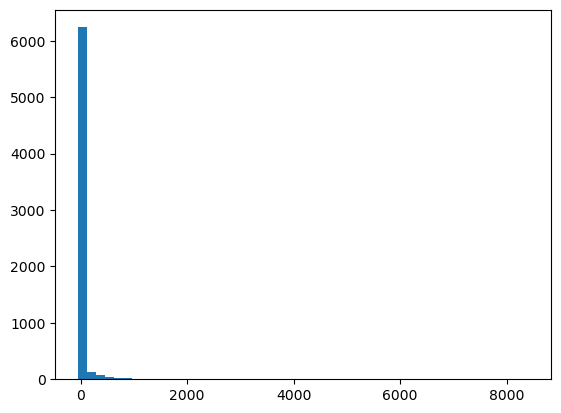

In [130]:
plt.hist(x=ndf.groupby('adgroup_id').agg({'profit':sum}).reset_index()['profit'], bins=50)